# Simlação de Federated Learning Utilizando Framework do TensorFlow

## Declaração das Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from imutils import paths

# Variável para verificar o status de cada cliente.
debug = 0

import time
start_time = time.time()

2022-10-09 10:44:45.428247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tiago.linhares/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-09 10:44:45.428276: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Declaração de Funções

In [2]:
# Função para carregar as Imagens.
# As imagens devem estar em diretórios diferentes.
def load(paths, verbose=-1):

    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # Carrega a imagem e extrai a classe do rótulo       
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # Mostra atualização de leituras das imagens através de uma verbose
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # Retorna uma tupla com os dados e os rótulos.
    
    return data, labels

# Função que define os clientes/membros do aprendizado federado
# Esta função retorna um dicionário com as chaves dos respectivos clientes
# Além do valor dos fragmentos de dados (Uma tupla contendo uma lista de imagens com rótulos)
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  


    # Divive um parcela dos dados para cada cliente
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    # número de clientes deve ser o mesmo número de parcelas dos dados
    assert(len(shards) == len(client_names))
    
    # Retorna um dicionário de cada cliente contendo uma parte de dados
    return {client_names[i] : shards[i] for i in range(len(client_names))} 


# Recebe o fragmento de dados do cliente e transforma em um objeto
def batch_data(data_shard, bs=32):
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count

# Função para dimensionar os pesos de um modelo
def scale_model_weights(weight, scalar):

    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


# Retorna a soma dos pesos escalados. 
# É equivalente à média escalonada dos pesos
def sum_scaled_weights(scaled_weight_list):
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad

# Função que realiza o teste do modelo após o treinamento.
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

## Declaração de Classes

In [3]:
class SimpleMLP:
    # MLP 
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
    # CNN
#     def build(shape, classes):
#         model = Sequential()
#         model.add(Input(shape=(shape[0], shape[1], shape[2])))
#         #model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Flatten())
#         model.add(Dense(32))
#         model.add(Dense(classes))
#         model.add(Activation("softmax"))
#         return model

## Diretório dos Dados

In [4]:
# Diretório padrão do mnist no lasid
img_path = '/data/dataset/mnist/trainingSet/trainingSet'

# Obtém uma lista contendo os múltiplos caminhos de cada diretório
# No caso do mnist são 8 diretórios
image_paths = list(paths.list_images(img_path))

# Aplica a função de carregar os dados
image_list, label_list = load(image_paths, verbose=10000)

# Binariza os rótulos
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


## Realiza a divisão de treinamento e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [6]:
len(X_train), len(X_test), len(y_train), len(y_test)


(37800, 4200, 37800, 4200)

## Realiza Criação dos Clientes

In [7]:
# Utiliza a função declarada anteriormente para criar novos clientes
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [8]:
# client_names = ['{}_{}'.format('client', i+1) for i in range(100)]
# s = clients['client_1'][0][1]*0
# for c in client_names:
#     sum = clients[c][0][1]
#     for i in range(1,378):
#         sum = sum + clients[c][i][1]
        
#     s = s + sum/378
# s

## Processa e agrupa os dados de treinamento

In [9]:
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
# Processa e agrupa os dados de teste
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

2022-10-09 10:46:04.263095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tiago.linhares/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-10-09 10:46:04.263142: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-09 10:46:04.263164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lasid40): /proc/driver/nvidia/version does not exist
2022-10-09 10:46:04.263649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Definição de Algumas Configurações do Modelo

In [10]:
# Learning Rate => Taxa de aprendizagem (O quanto o modelo demora para convergir)
lr = 0.01

# Número de etapas de atualização do modelo global
comms_round = 300

# Tipo de perda
loss='categorical_crossentropy'

# Métrica de avaliação do modelo
metrics = ['accuracy']

optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )         

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Inicializa o Modelo Global

In [11]:
#(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # para MNIST
build_shape = 784

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

## Loop de execução principal

In [12]:
# Inicia o Ciclo de Treinamento Global
for comm_round in range(comms_round):
    
    # obtém os pesos do modelo global - servirá como peso inicial para todos os modelos locais
    global_weights = global_model.get_weights()
    
    # Inicializa a lista para coletar os pesos do modelo local após o dimensionamento
    scaled_local_weight_list = list()

    # Randomiza os dados dos clientes usando as chaves
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    # print(client_names, len(client_names))
    random.shuffle(client_names)
    
    # Descomentar para caso queira verificar as características dos clientes
#     if debug: 
#         # print('all_client_names', all_client_names)
#         print('client_names', client_names, len(client_names))
                
    
    # Percorre cada cliente e criar um novo modelo local
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        # Define o peso do modelo local para o peso do modelo global
        local_model.set_weights(global_weights)
        
        # Ajustar o modelo local com os dados do cliente
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        # Dimensiona os pesos do modelo e adicionar à lista
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        # Limpa sessão para liberar memória após cada rodada de comunicação
        K.clear_session()

    # Para obter a média de todo o modelo local, simplesmente pegamos a soma dos pesos escalonados    
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    # Atualiza o Modelo Global
    global_model.set_weights(average_weights)

    # Testa o modelo global e imprime as informações de cada round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

132/132 [==============================] - 0s 2ms/step
comm_round: 0 | global_acc: 49.024% | global_loss: 2.2648963928222656
132/132 [==============================] - 0s 2ms/step
comm_round: 1 | global_acc: 64.857% | global_loss: 2.2125556468963623
132/132 [==============================] - 0s 2ms/step
comm_round: 2 | global_acc: 69.595% | global_loss: 2.125474691390991
132/132 [==============================] - 0s 2ms/step
comm_round: 3 | global_acc: 74.286% | global_loss: 2.036379098892212
132/132 [==============================] - 0s 2ms/step
comm_round: 4 | global_acc: 77.905% | global_loss: 1.9575155973434448
132/132 [==============================] - 0s 2ms/step
comm_round: 5 | global_acc: 79.738% | global_loss: 1.8952754735946655
132/132 [==============================] - 0s 2ms/step
comm_round: 6 | global_acc: 81.667% | global_loss: 1.8520911931991577
132/132 [==============================] - 0s 2ms/step
comm_round: 7 | global_acc: 83.667% | global_loss: 1.8144118785858154
13

## Imprime Gráfico do Desempenho do Modelo Global

Mnist | total comm rounds 300


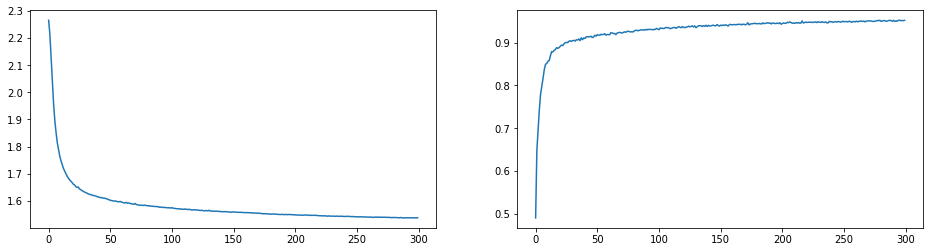

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Mnist | total comm rounds', len(global_acc_list))

In [14]:
csv_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
csv_df.to_csv('MNIST_TFF.csv',index=False)


In [15]:
timeTotal = time.time() - start_time
print("Time = %3.1f s" % timeTotal)

Time = 1477.6 s
